In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [2]:
np.random.seed(0)

In [3]:
!ls /home/ankit/Downloads/pretrained-pytorch-models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [4]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [5]:
!cp /home/ankit/Downloads/pretrained-pytorch-models/* ~/.torch/models/

In [6]:
!ls ~/.torch/models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [7]:
!ls /home/ankit/Downloads/dog-breed-idnetification/

labels.csv  sample_submission.csv  test  train


In [8]:
INPUT_SIZE = 224
NUM_CLASSES = 16
data_dir = '/home/ankit/Downloads/dog-breed-idnetification/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))),len(sample_submission))

10222 10222
10357 10357


In [9]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
selected_breed_list

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel']

In [10]:
labels = labels[labels['breed'].isin(selected_breed_list)]

In [11]:
labels['target'] = 1
labels

,id,breed,target
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,1
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,1
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,1
29,00bee065dcec471f26394855c5c2f3de,cairn,1
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,1
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,1
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed,1
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,1
80,01ee3c7ff9bcaba9874183135877670e,entlebucher,1
88,021b5a49189665c0442c19b5b33e8cf1,entlebucher,1


In [12]:
#labels.groupby('breed')['id'].rank(ascending=False)

In [13]:

labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
labels.pivot


<bound method DataFrame.pivot of                                      id                 breed  target
8      003df8b8a8b05244b1d920bb6cf451f9               basenji       1
9      0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound       1
12     00693b8bc2470375cc744a6391d397ec           maltese_dog       1
29     00bee065dcec471f26394855c5c2f3de                 cairn       1
48     013f8fdf6d638c7bb042f5f17e8a9fdc       tibetan_terrier       1
57     0162b3e0144fb1d1ab82fbff3ace9938              shih-tzu       1
70     01b36cb1b80ab8c3a7d2b7128ad21bdc               samoyed       1
79     01e787576c003930f96c966f9c3e1d44    scottish_deerhound       1
80     01ee3c7ff9bcaba9874183135877670e           entlebucher       1
88     021b5a49189665c0442c19b5b33e8cf1           entlebucher       1
90     022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog       1
102    0267c5f1acbab52ae4a7927e0398612b              airedale       1
105    0287b3374c33346e2b41f73af3a36261              leon

In [14]:
train = labels_pivot.sample(frac=0.8)
train

breed,id,afghan_hound,airedale,basenji,beagle,bernese_mountain_dog,cairn,entlebucher,great_pyrenees,japanese_spaniel,leonberg,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
942,8c547b5df1aff986fa67f9efc97459b9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1711,f591763666758b806f71459819ce8602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1688,f1a9a63f0ec70494ec2050de0fd39402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
795,79b05087af93c305981bfe509659391e,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581,58154ab6841198957a50526106c72d72,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,941dff46bad4b57495199709b7ab04b5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1183,ad282d2da0cc82233dbc487e8ca80aed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
161,15b5cd948f5bcbb7a4f5b1904de4c6d5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,680d7f247d8303c0cd1c4a1283bb3d25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1754,fb9c8b7e0b70b201898d930ed71163b6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
valid

breed,id,afghan_hound,airedale,basenji,beagle,bernese_mountain_dog,cairn,entlebucher,great_pyrenees,japanese_spaniel,leonberg,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
11,0267c5f1acbab52ae4a7927e0398612b,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,03dfefdb2939388f7ca9578cb7c4a2b9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24,03e1d2ee5fd90aef036c90a9e7f81177,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,041b3b8a40b587a486276ac15edd9eaf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28,04fb4d719e9fe2b6ffe32d9ae7be8a22,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,055cfac66e5d67756ab05d02baeeb04c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0566a60d7504a6fad4161d0ef2765a34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,058d4bfce39c9f1157ca4c1b019bbf1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41,06448bf4366760660b6a7611d93d7533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,06557d54077c5265ecdcd7273c9c38ca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
print(train.shape, valid.shape)

(1422, 17) (355, 17)


In [17]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]





In [18]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [19]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data 

torch.Size([4, 3, 224, 224]) torch.Size([4])


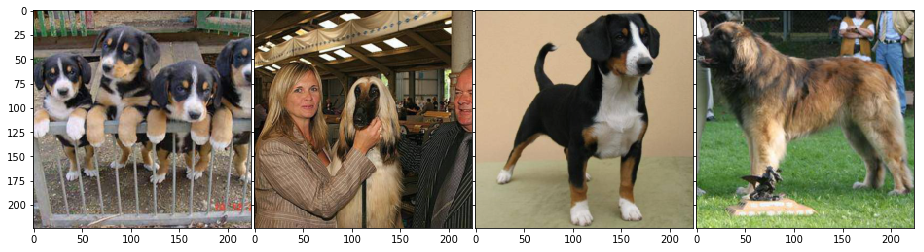

In [20]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])


# ResNet50
Just try the model

In [21]:
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


torch.Size([4, 1000])



The model seems to work OK. Resnet outputs probabilities for the imagenet 1000 labels as expected.
Replace last layer and train

Will replace the last layer with one that predicts the 16 classes. The network weights will be fixed expected for the last layer that is trained.


In [22]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model



In [23]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 16)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}


In [24]:
start_time = time.time()
start_time


1533557470.620487

In [25]:
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-pa

Epoch [0/1] train loss: 0.3770 acc: 0.0000 valid loss: 0.0662 acc: 0.0000


/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Metho

Epoch [1/1] train loss: 0.1702 acc: 0.0000 valid loss: 0.0431 acc: 0.0000
Best val Acc: 0.000000
Training time:  20.488133 minutes


In [26]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
       
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return


/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data 

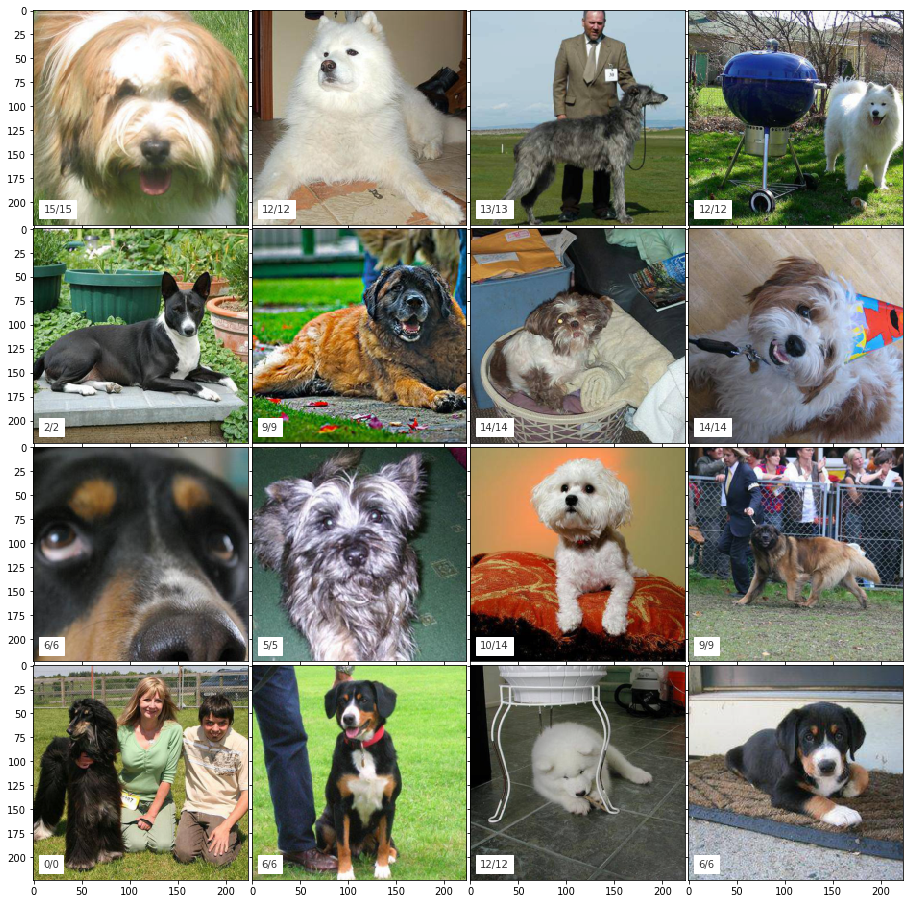

In [27]:


visualize_model(dloaders, resnet)





This kernel was mainly to test using transfer learning in kernels using PyTorch. Training is slow in CPU but it works.
